In [2]:
import os

import rdflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load crowd sourcing data

In [3]:
filepath = os.path.join('..', '..', 'setup_data', 'crowdsourced_data', 'crowd_data.tsv')

In [4]:
crowd_df = pd.read_csv(filepath, sep='\t')

In [5]:
crowd_df

,HITId,HITTypeId,Title,Reward,AssignmentId,WorkerId,AssignmentStatus,WorkTimeInSeconds,LifetimeApprovalRate,Input1ID,Input2ID,Input3ID,AnswerID,AnswerLabel,FixPosition,FixValue
0,1,7QT,Is this triple correct or incorrect?,$0.50,1,2133ICYWE97,Submitted,60,99%,wd:Q11621,wdt:P2142,792910554,1.0,CORRECT,NaN,NaN
1,1,7QT,Is this triple correct or incorrect?,$0.50,2,2133U7HKDLO,Submitted,40,40%,wd:Q11621,wdt:P2142,792910554,1.0,CORRECT,yes,yes
2,1,7QT,Is this triple correct or incorrect?,$0.50,3,928UJANWZ12,Submitted,50,98%,wd:Q11621,wdt:P2142,792910554,2.0,INCORRECT,NaN,NaN
3,1,7QT,Is this triple correct or incorrect?,$0.50,4,1726JMZQW,Submitted,80,70%,wd:Q11621,wdt:P2142,792910554,1.0,CORRECT,NaN,NaN
4,1,7QT,Is this triple correct or incorrect?,$0.50,5,2134U7HKDMM,Submitted,2,70%,wd:Q11621,wdt:P2142,792910554,1.0,CORRECT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,61,9QT,Is this triple correct or incorrect?,$0.50,301,AALKMII97,Submitted,240,98%,wd:Q1288004,wdt:P1412,wd:Q13330,2.0,INCORRECT,Object,Q1860
301,61,9QT,Is this triple correct or incorrect?,$0.50,302,HHCKW1111,Submitted,200,80%,wd:Q1288004,wdt:P1412,wd:Q13330,1.0,CORRECT,NaN,NaN
302,61,9QT,Is this triple correct or incorrect?,$0.50,303,GGUI83657S,Submitted,120,85%,wd:Q1288004,wdt:P1412,wd:Q13330,1.0,CORRECT,NaN,NaN
303,61,9QT,Is this triple correct or incorrect?,$0.50,304,WWHL098SA43,Submitted,10,69%,wd:Q1288004,wdt:P1412,wd:Q13330,2.0,INCORRECT,NaN,NaN


In [22]:
crowd_df[['HITId', 'AnswerLabel', 'Title']]\
    .groupby(['HITId', 'AnswerLabel'])\
    .count()
    #.groupby(level=0).aggregate(lambda x: x['Title']/x['Title'].sum())

Title
HITId AnswerLabel       
1     CORRECT          4
      INCORRECT        1
2     CORRECT          4
      INCORRECT        1
3     CORRECT          3
...                  ...
59    INCORRECT        2
60    CORRECT          2
      INCORRECT        3
61    CORRECT          2
      INCORRECT        3

[117 rows x 1 columns]

## Remove malicious workers

### Check overall behaviour with plots

For this, let's use their lifetime approval, how long they took most of the times to answer the questions, and if they filled out the Fix position and FixValue when they marked something as incorrect

<AxesSubplot:ylabel='Frequency'>

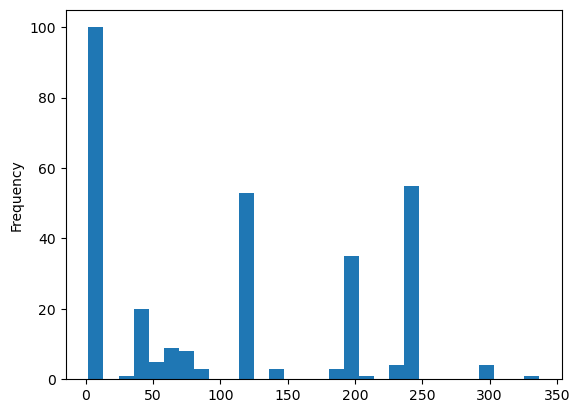

In [28]:
crowd_df.WorkTimeInSeconds.plot.hist(bins=30)

<AxesSubplot:ylabel='Frequency'>

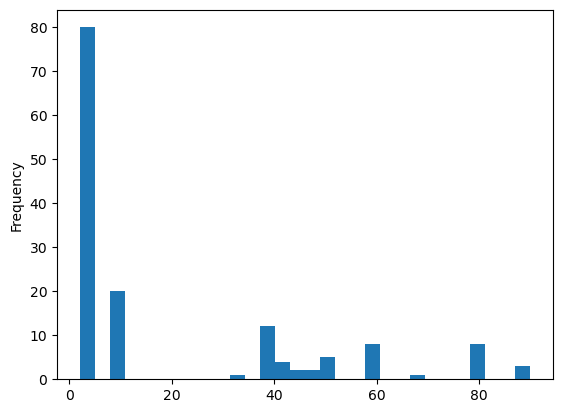

In [29]:
crowd_df.WorkTimeInSeconds[crowd_df.WorkTimeInSeconds < 100].plot.hist(bins=30)

Taking less than 20 seconds for this task seems a bit too little. Less than 30 seems cutting it a bit too short but they could be very fast workers, depending on their scores

<AxesSubplot:ylabel='Frequency'>

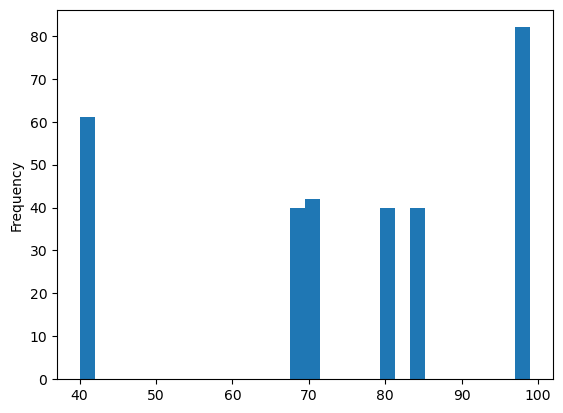

In [31]:
crowd_df.LifetimeApprovalRate.map(lambda x: float(x.strip("%"))).plot.hist(bins=30)

Let's check the distribution of time of those under 60%

<AxesSubplot:ylabel='Frequency'>

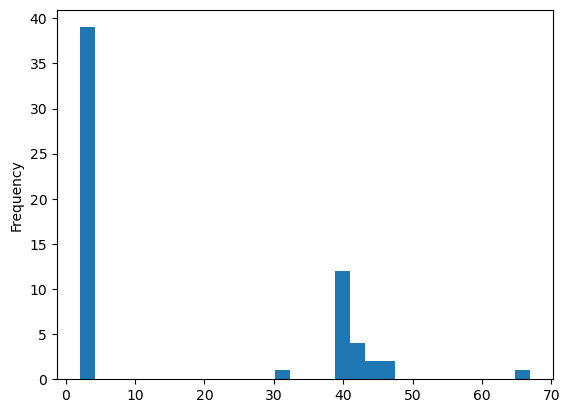

In [32]:
crowd_df[crowd_df.LifetimeApprovalRate.map(lambda x: float(x.strip("%"))) < 60].WorkTimeInSeconds.plot.hist(bins=30)

They can take between 2 seconds and 70. Let's check the scores of those that take less than 20 seconds

<AxesSubplot:ylabel='Frequency'>

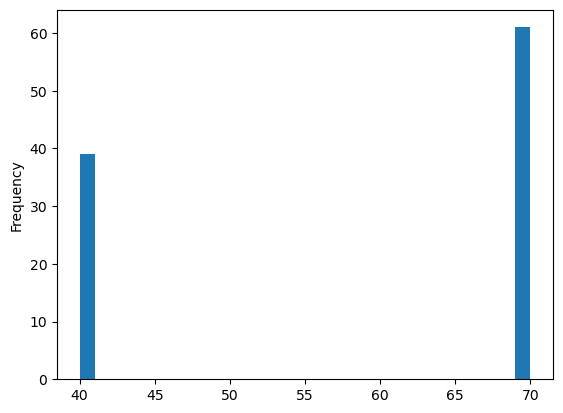

In [33]:
crowd_df[crowd_df.WorkTimeInSeconds < 20].LifetimeApprovalRate.map(lambda x: float(x.strip("%"))) .plot.hist(bins=30)

Seems like some people with 70% score suspiciously fast. Let's check with quantiles instead

### Let's summarize user behavior

In [119]:
rater_behavior = crowd_df.groupby(['WorkerId', 'LifetimeApprovalRate'])[['WorkTimeInSeconds']].quantile(0.8)
rater_behavior

,,WorkTimeInSeconds
WorkerId,LifetimeApprovalRate,
1726JMZQW,70%,240.0
2133ICYWE97,99%,120.0
2133U7HKDLO,40%,43.0
2134U7HKDMM,70%,2.0
928UJANWZ12,98%,240.0
AALKMII97,98%,240.0
AALKMII98,98%,240.0
GGUI83657S,85%,120.0
HHCKW1111,80%,200.0


In [120]:
num_wrong_na_fields_per_worker = crowd_df[crowd_df.AnswerLabel == 'INCORRECT'][['WorkerId', 'FixPosition', 'FixValue']].set_index('WorkerId')\
    .isna().sum(axis=1)\
    .groupby(level=0).sum() * 0.5

num_incorrect_rates_per_worker = crowd_df[crowd_df.AnswerLabel == 'INCORRECT'].WorkerId.value_counts()

In [121]:
num_wrong_na_fields_per_worker = pd.DataFrame(num_wrong_na_fields_per_worker, columns=['num_wrong_nas']).join(pd.DataFrame(num_incorrect_rates_per_worker.rename('num_rates_incorrect')), how='left')
num_wrong_na_fields_per_worker['prop_wrong_nas'] = num_wrong_na_fields_per_worker.num_wrong_nas / num_wrong_na_fields_per_worker.num_rates_incorrect

In [122]:
num_wrong_na_fields_per_worker

,num_wrong_nas,num_rates_incorrect,prop_wrong_nas
WorkerId,,,
1726JMZQW,7.5,9,0.833333
2133ICYWE97,5.5,10,0.550000
2134U7HKDMM,12.0,12,1.000000
928UJANWZ12,8.5,11,0.772727
AALKMII97,0.5,12,0.041667
AALKMII98,0.0,11,0.000000
GGUI83657S,0.0,20,0.000000
HHCKW1111,0.5,21,0.023810
LPQMUDT6729,7.0,7,1.000000


Let's check which workers mark everything as wrong or correct

In [123]:
num_rates_per_worker =  crowd_df.WorkerId.value_counts().rename('num_rates')
num_rates_per_worker = pd.DataFrame(num_rates_per_worker)
num_rates_per_worker.index.name ='WorkerId'

In [124]:
prop_correct_incorrect = crowd_df.groupby(['WorkerId', 'AnswerLabel'])[['AnswerID']]\
    .count()\
    .join(num_rates_per_worker)

prop_correct_incorrect['prop_answer'] = prop_correct_incorrect.AnswerID / prop_correct_incorrect.num_rates
prop_correct_incorrect = prop_correct_incorrect\
    .reset_index()\
    .pivot_table(index='WorkerId', columns='AnswerLabel', values='prop_answer', fill_value=0)

In [125]:
prop_correct_incorrect

AnswerLabel,CORRECT,INCORRECT
WorkerId,,
1726JMZQW,0.571429,0.428571
2133ICYWE97,0.523810,0.476190
2133U7HKDLO,1.000000,0.000000
2134U7HKDMM,0.428571,0.571429
928UJANWZ12,0.476190,0.523810
AALKMII97,0.400000,0.600000
AALKMII98,0.450000,0.550000
GGUI83657S,0.500000,0.500000
HHCKW1111,0.475000,0.525000


In [127]:
rater_behavior = rater_behavior\
    .join(num_wrong_na_fields_per_worker[['prop_wrong_nas']])\
    .join(prop_correct_incorrect)
rater_behavior

,,WorkTimeInSeconds,prop_wrong_nas,CORRECT,INCORRECT
WorkerId,LifetimeApprovalRate,,,,
1726JMZQW,70%,240.0,0.833333,0.571429,0.428571
2133ICYWE97,99%,120.0,0.550000,0.523810,0.476190
2133U7HKDLO,40%,43.0,NaN,1.000000,0.000000
2134U7HKDMM,70%,2.0,1.000000,0.428571,0.571429
928UJANWZ12,98%,240.0,0.772727,0.476190,0.523810
AALKMII97,98%,240.0,0.041667,0.400000,0.600000
AALKMII98,98%,240.0,0.000000,0.450000,0.550000
GGUI83657S,85%,120.0,0.000000,0.500000,0.500000
HHCKW1111,80%,200.0,0.023810,0.475000,0.525000


In [132]:
malicious_workers = []

### Let's check all workers with an approval rate under 40%

The ones that take an impossible small ammount of time (2 seconds) either never mark how to correct the incorrect answers or fill it with dummy values. The one that took longer always marked correct and filled yes in eveything

In [92]:
crowd_df[crowd_df.WorkerId == '2133U7HKDLO']

,HITId,HITTypeId,Title,Reward,AssignmentId,WorkerId,AssignmentStatus,WorkTimeInSeconds,LifetimeApprovalRate,Input1ID,Input2ID,Input3ID,AnswerID,AnswerLabel,FixPosition,FixValue
1,1,7QT,Is this triple correct or incorrect?,$0.50,2,2133U7HKDLO,Submitted,40,40%,wd:Q11621,wdt:P2142,792910554,1.0,CORRECT,yes,yes
9,2,7QT,Is this triple correct or incorrect?,$0.50,10,2133U7HKDLO,Submitted,40,40%,wd:Q603545,wdt:P2142,4300000,1.0,CORRECT,yes,yes
13,3,7QT,Is this triple correct or incorrect?,$0.50,14,2133U7HKDLO,Submitted,46,40%,wd:Q16911843,wdt:P577,2014-01-18,1.0,CORRECT,yes,yes
17,4,7QT,Is this triple correct or incorrect?,$0.50,18,2133U7HKDLO,Submitted,40,40%,wd:Q132863,wdt:P2142,969023261,1.0,CORRECT,yes,yes
21,5,7QT,Is this triple correct or incorrect?,$0.50,22,2133U7HKDLO,Submitted,40,40%,wd:Q1628022,wdt:P577,1951-01-01,1.0,CORRECT,yes,yes
27,6,7QT,Is this triple correct or incorrect?,$0.50,28,2133U7HKDLO,Submitted,40,40%,wd:Q48313910,wdt:P577,2018-02-24,1.0,CORRECT,yes,yes
34,7,7QT,Is this triple correct or incorrect?,$0.50,35,2133U7HKDLO,Submitted,32,40%,wd:Q171300,wdt:P2142,267000000,1.0,CORRECT,yes,yes
38,8,7QT,Is this triple correct or incorrect?,$0.50,39,2133U7HKDLO,Submitted,39,40%,wd:Q217010,wdt:P2142,698491347,1.0,CORRECT,yes,yes
43,9,7QT,Is this triple correct or incorrect?,$0.50,44,2133U7HKDLO,Submitted,46,40%,wd:Q4993462,wdt:P577,2008-08-29,1.0,CORRECT,yes,yes
46,10,7QT,Is this triple correct or incorrect?,$0.50,47,2133U7HKDLO,Submitted,45,40%,wd:Q7033842,wdt:P577,1996-06-01,1.0,CORRECT,yes,yes


In [129]:
crowd_df[crowd_df.WorkerId == 'LPQMUDT6729']

,HITId,HITTypeId,Title,Reward,AssignmentId,WorkerId,AssignmentStatus,WorkTimeInSeconds,LifetimeApprovalRate,Input1ID,Input2ID,Input3ID,AnswerID,AnswerLabel,FixPosition,FixValue
108,22,8QT,Is this triple correct or incorrect?,$0.50,109,LPQMUDT6729,Submitted,4,40%,wd:Q1720855,wdt:P577,2010-10-01,2.0,INCORRECT,NaN,NaN
113,23,8QT,Is this triple correct or incorrect?,$0.50,114,LPQMUDT6729,Submitted,4,40%,wd:Q598752,wdt:P577,2001-01-01,2.0,INCORRECT,NaN,NaN
118,24,8QT,Is this triple correct or incorrect?,$0.50,119,LPQMUDT6729,Submitted,4,40%,wd:Q427386,wdt:P2142,176997186,1.0,INCORRECT,NaN,NaN
123,25,8QT,Is this triple correct or incorrect?,$0.50,124,LPQMUDT6729,Submitted,4,40%,wd:Q321561,wdt:P577,1982-01-01,1.0,CORRECT,NaN,NaN
128,26,8QT,Is this triple correct or incorrect?,$0.50,129,LPQMUDT6729,Submitted,4,40%,wd:Q1410031,wdt:P577,2010-10-01,1.0,CORRECT,NaN,NaN
134,27,8QT,Is this triple correct or incorrect?,$0.50,135,LPQMUDT6729,Submitted,4,40%,wd:Q20001199,wdt:P2142,863756050,1.0,CORRECT,NaN,NaN
137,28,8QT,Is this triple correct or incorrect?,$0.50,138,LPQMUDT6729,Submitted,4,40%,wd:Q15055043,wdt:P2142,511200000,1.0,CORRECT,NaN,NaN
143,29,8QT,Is this triple correct or incorrect?,$0.50,144,LPQMUDT6729,Submitted,4,40%,wd:Q639070,wdt:P161,wd:Q2865083,1.0,CORRECT,NaN,NaN
149,30,8QT,Is this triple correct or incorrect?,$0.50,150,LPQMUDT6729,Submitted,4,40%,wd:Q23999890,wdt:P577,2015-01-05,1.0,CORRECT,NaN,NaN
154,31,8QT,Is this triple correct or incorrect?,$0.50,155,LPQMUDT6729,Submitted,4,40%,wd:Q841233,wdt:P2142,10696220,2.0,INCORRECT,NaN,NaN


In [130]:
crowd_df[crowd_df.WorkerId == 'QZAHIFT8263']

,HITId,HITTypeId,Title,Reward,AssignmentId,WorkerId,AssignmentStatus,WorkTimeInSeconds,LifetimeApprovalRate,Input1ID,Input2ID,Input3ID,AnswerID,AnswerLabel,FixPosition,FixValue
209,42,9QT,Is this triple correct or incorrect?,$0.50,210,QZAHIFT8263,Submitted,4,40%,wd:Q1780602,wdt:P921,wd:Q295093,1.0,CORRECT,NaN,NaN
214,43,9QT,Is this triple correct or incorrect?,$0.50,215,QZAHIFT8263,Submitted,2,40%,wd:Q610633,wdt:P2554,wd:Q1700810,1.0,CORRECT,NaN,NaN
217,44,9QT,Is this triple correct or incorrect?,$0.50,218,QZAHIFT8263,Submitted,2,40%,wd:Q2188914,wdt:P161,wd:Q2416526,2.0,INCORRECT,100,100
223,45,9QT,Is this triple correct or incorrect?,$0.50,224,QZAHIFT8263,Submitted,2,40%,wd:Q1032889,wdt:P58,wd:Q4762311,1.0,CORRECT,NaN,NaN
229,46,9QT,Is this triple correct or incorrect?,$0.50,230,QZAHIFT8263,Submitted,2,40%,wd:Q209538,wdt:P3650,wd:Q28732983,1.0,CORRECT,NaN,NaN
233,47,9QT,Is this triple correct or incorrect?,$0.50,234,QZAHIFT8263,Submitted,2,40%,wd:Q31202708,wdt:P3092,wd:Q4805527,NaN,CORRECT,NaN,NaN
236,48,9QT,Is this triple correct or incorrect?,$0.50,237,QZAHIFT8263,Submitted,2,40%,wd:Q2576243,wdt:P364,wd:Q1860,1.0,CORRECT,NaN,NaN
242,49,9QT,Is this triple correct or incorrect?,$0.50,243,QZAHIFT8263,Submitted,2,40%,wd:Q4335275,wdt:P520,wd:Q52382294,1.0,CORRECT,NaN,NaN
248,50,9QT,Is this triple correct or incorrect?,$0.50,249,QZAHIFT8263,Submitted,2,40%,wd:Q931557,wdt:P750,wd:Q80948336,1.0,CORRECT,NaN,NaN
252,51,9QT,Is this triple correct or incorrect?,$0.50,253,QZAHIFT8263,Submitted,2,40%,wd:Q2235250,wdt:P161,wd:Q599673,1.0,CORRECT,NaN,NaN


Let's remove all of them

In [133]:
malicious_workers += ['2133U7HKDLO', 'LPQMUDT6729', 'QZAHIFT8263']

In [138]:
rater_behavior.drop(malicious_workers, inplace=True)

**This could be implemented as a rule: all those with a LifeTimeApprovalRate under 60% and that took less than 20 seconds for 80% of cases will be removed**

### Users that mark way to many ansers as correct or incorrect

In [139]:
rater_behavior[(rater_behavior.CORRECT > 0.7) | (rater_behavior.INCORRECT > 0.7)]

,,WorkTimeInSeconds,prop_wrong_nas,CORRECT,INCORRECT
WorkerId,LifetimeApprovalRate,,,,
WWHL098SA43,69%,10.0,0.111111,0.1,0.9


In [140]:
crowd_df[crowd_df.WorkerId == 'WWHL098SA43']

,HITId,HITTypeId,Title,Reward,AssignmentId,WorkerId,AssignmentStatus,WorkTimeInSeconds,LifetimeApprovalRate,Input1ID,Input2ID,Input3ID,AnswerID,AnswerLabel,FixPosition,FixValue
208,42,9QT,Is this triple correct or incorrect?,$0.50,209,WWHL098SA43,Submitted,10,69%,wd:Q1780602,wdt:P921,wd:Q295093,2.0,INCORRECT,I don't understand,I don't understand
213,43,9QT,Is this triple correct or incorrect?,$0.50,214,WWHL098SA43,Submitted,10,69%,wd:Q610633,wdt:P2554,wd:Q1700810,2.0,INCORRECT,I don't understand,I don't understand
219,44,9QT,Is this triple correct or incorrect?,$0.50,220,WWHL098SA43,Submitted,10,69%,wd:Q2188914,wdt:P161,wd:Q2416526,2.0,INCORRECT,I don't understand,I don't understand
224,45,9QT,Is this triple correct or incorrect?,$0.50,225,WWHL098SA43,Submitted,10,69%,wd:Q1032889,wdt:P58,wd:Q4762311,2.0,INCORRECT,I don't understand,I don't understand
228,46,9QT,Is this triple correct or incorrect?,$0.50,229,WWHL098SA43,Submitted,10,69%,wd:Q209538,wdt:P3650,wd:Q28732983,2.0,INCORRECT,I don't understand,I don't understand
234,47,9QT,Is this triple correct or incorrect?,$0.50,235,WWHL098SA43,Submitted,10,69%,wd:Q31202708,wdt:P3092,wd:Q4805527,2.0,INCORRECT,I don't understand,I don't understand
239,48,9QT,Is this triple correct or incorrect?,$0.50,240,WWHL098SA43,Submitted,10,69%,wd:Q2576243,wdt:P364,wd:Q1860,2.0,INCORRECT,I don't understand,I don't understand
244,49,9QT,Is this triple correct or incorrect?,$0.50,245,WWHL098SA43,Submitted,10,69%,wd:Q4335275,wdt:P520,wd:Q52382294,2.0,INCORRECT,I don't understand,I don't understand
249,50,9QT,Is this triple correct or incorrect?,$0.50,250,WWHL098SA43,Submitted,10,69%,wd:Q931557,wdt:P750,wd:Q80948336,2.0,INCORRECT,I don't understand,I don't understand
254,51,9QT,Is this triple correct or incorrect?,$0.50,255,WWHL098SA43,Submitted,10,69%,wd:Q2235250,wdt:P161,wd:Q599673,2.0,INCORRECT,I don't understand,I don't understand


Seems the user did not understand the task. They will also be removed

In [141]:
malicious_workers += ['WWHL098SA43']

In [143]:
rater_behavior.drop(['WWHL098SA43'], inplace=True)

**This could be implemented as a rule, all those with percentage of correct or incorrect labels over 70% will be removed**

### Users with a higher rating but that take too little

In [147]:
rater_behavior

,,WorkTimeInSeconds,prop_wrong_nas,CORRECT,INCORRECT
WorkerId,LifetimeApprovalRate,,,,
1726JMZQW,70%,240.0,0.833333,0.571429,0.428571
2133ICYWE97,99%,120.0,0.550000,0.523810,0.476190
2134U7HKDMM,70%,2.0,1.000000,0.428571,0.571429
928UJANWZ12,98%,240.0,0.772727,0.476190,0.523810
AALKMII97,98%,240.0,0.041667,0.400000,0.600000
AALKMII98,98%,240.0,0.000000,0.450000,0.550000
GGUI83657S,85%,120.0,0.000000,0.500000,0.500000
HHCKW1111,80%,200.0,0.023810,0.475000,0.525000
ZZHL098SA43,69%,2.0,0.500000,0.600000,0.400000


There are some weird cases. Worker ID `ZZHL098SA43` seems to put the correct answer when they mark why they are wrong, but seem to have a lot of false positives when they claim something is correct. How they manage to this in 2 seconds is weird though haha


In [91]:
crowd_df[crowd_df.WorkerId == 'ZZHL098SA43']

,HITId,HITTypeId,Title,Reward,AssignmentId,WorkerId,AssignmentStatus,WorkTimeInSeconds,LifetimeApprovalRate,Input1ID,Input2ID,Input3ID,AnswerID,AnswerLabel,FixPosition,FixValue
109,22,8QT,Is this triple correct or incorrect?,$0.50,110,ZZHL098SA43,Submitted,2,69%,wd:Q1720855,wdt:P577,2010-10-01,1.0,CORRECT,NaN,NaN
114,23,8QT,Is this triple correct or incorrect?,$0.50,115,ZZHL098SA43,Submitted,2,69%,wd:Q598752,wdt:P577,2001-01-01,2.0,INCORRECT,Object,2011-01-01
119,24,8QT,Is this triple correct or incorrect?,$0.50,120,ZZHL098SA43,Submitted,2,69%,wd:Q427386,wdt:P2142,176997186,2.0,INCORRECT,Object,176997168
124,25,8QT,Is this triple correct or incorrect?,$0.50,125,ZZHL098SA43,Submitted,2,69%,wd:Q321561,wdt:P577,1982-01-01,1.0,CORRECT,NaN,NaN
129,26,8QT,Is this triple correct or incorrect?,$0.50,130,ZZHL098SA43,Submitted,2,69%,wd:Q1410031,wdt:P577,2010-10-01,1.0,CORRECT,NaN,NaN
130,27,8QT,Is this triple correct or incorrect?,$0.50,131,ZZHL098SA43,Submitted,2,69%,wd:Q20001199,wdt:P2142,863756050,2.0,INCORRECT,Object,863756051
138,28,8QT,Is this triple correct or incorrect?,$0.50,139,ZZHL098SA43,Submitted,2,69%,wd:Q15055043,wdt:P2142,511200000,1.0,CORRECT,NaN,NaN
144,29,8QT,Is this triple correct or incorrect?,$0.50,145,ZZHL098SA43,Submitted,2,69%,wd:Q639070,wdt:P161,wd:Q2865083,1.0,CORRECT,NaN,NaN
147,30,8QT,Is this triple correct or incorrect?,$0.50,148,ZZHL098SA43,Submitted,2,69%,wd:Q23999890,wdt:P577,2015-01-05,1.0,CORRECT,NaN,NaN
153,31,8QT,Is this triple correct or incorrect?,$0.50,154,ZZHL098SA43,Submitted,2,69%,wd:Q841233,wdt:P2142,10696220,1.0,CORRECT,NaN,NaN


This user has some correct and some wrong answers and they never mark what would be the correct answer

In [146]:
crowd_df[crowd_df.WorkerId == '2134U7HKDMM']


,HITId,HITTypeId,Title,Reward,AssignmentId,WorkerId,AssignmentStatus,WorkTimeInSeconds,LifetimeApprovalRate,Input1ID,Input2ID,Input3ID,AnswerID,AnswerLabel,FixPosition,FixValue
4,1,7QT,Is this triple correct or incorrect?,$0.50,5,2134U7HKDMM,Submitted,2,70%,wd:Q11621,wdt:P2142,792910554,1.0,CORRECT,NaN,NaN
5,2,7QT,Is this triple correct or incorrect?,$0.50,6,2134U7HKDMM,Submitted,2,70%,wd:Q603545,wdt:P2142,4300000,2.0,INCORRECT,NaN,NaN
12,3,7QT,Is this triple correct or incorrect?,$0.50,13,2134U7HKDMM,Submitted,2,70%,wd:Q16911843,wdt:P577,2014-01-18,2.0,INCORRECT,NaN,NaN
19,4,7QT,Is this triple correct or incorrect?,$0.50,20,2134U7HKDMM,Submitted,2,70%,wd:Q132863,wdt:P2142,969023261,1.0,CORRECT,NaN,NaN
24,5,7QT,Is this triple correct or incorrect?,$0.50,25,2134U7HKDMM,Submitted,2,70%,wd:Q1628022,wdt:P577,1951-01-01,2.0,INCORRECT,NaN,NaN
29,6,7QT,Is this triple correct or incorrect?,$0.50,30,2134U7HKDMM,Submitted,2,70%,wd:Q48313910,wdt:P577,2018-02-24,1.0,CORRECT,NaN,NaN
32,7,7QT,Is this triple correct or incorrect?,$0.50,33,2134U7HKDMM,Submitted,2,70%,wd:Q171300,wdt:P2142,267000000,2.0,INCORRECT,NaN,NaN
39,8,7QT,Is this triple correct or incorrect?,$0.50,40,2134U7HKDMM,Submitted,2,70%,wd:Q217010,wdt:P2142,698491347,1.0,CORRECT,NaN,NaN
44,9,7QT,Is this triple correct or incorrect?,$0.50,45,2134U7HKDMM,Submitted,2,70%,wd:Q4993462,wdt:P577,2008-08-29,1.0,CORRECT,NaN,NaN
49,10,7QT,Is this triple correct or incorrect?,$0.50,50,2134U7HKDMM,Submitted,2,70%,wd:Q7033842,wdt:P577,1996-06-01,2.0,INCORRECT,NaN,NaN


In [148]:
rater_behavior

,,WorkTimeInSeconds,prop_wrong_nas,CORRECT,INCORRECT
WorkerId,LifetimeApprovalRate,,,,
1726JMZQW,70%,240.0,0.833333,0.571429,0.428571
2133ICYWE97,99%,120.0,0.550000,0.523810,0.476190
2134U7HKDMM,70%,2.0,1.000000,0.428571,0.571429
928UJANWZ12,98%,240.0,0.772727,0.476190,0.523810
AALKMII97,98%,240.0,0.041667,0.400000,0.600000
AALKMII98,98%,240.0,0.000000,0.450000,0.550000
GGUI83657S,85%,120.0,0.000000,0.500000,0.500000
HHCKW1111,80%,200.0,0.023810,0.475000,0.525000
ZZHL098SA43,69%,2.0,0.500000,0.600000,0.400000


It does not make sense that they took exactly 2 seconds for all of the examples (they might have used a service or something to automate the answers), let's remove them

In [149]:
malicious_workers += ['ZZHL098SA43', '2134U7HKDMM']

In [150]:
rater_behavior.drop(['ZZHL098SA43', '2134U7HKDMM'], inplace=True)

In [151]:
rater_behavior

,,WorkTimeInSeconds,prop_wrong_nas,CORRECT,INCORRECT
WorkerId,LifetimeApprovalRate,,,,
1726JMZQW,70%,240.0,0.833333,0.571429,0.428571
2133ICYWE97,99%,120.0,0.550000,0.523810,0.476190
928UJANWZ12,98%,240.0,0.772727,0.476190,0.523810
AALKMII97,98%,240.0,0.041667,0.400000,0.600000
AALKMII98,98%,240.0,0.000000,0.450000,0.550000
GGUI83657S,85%,120.0,0.000000,0.500000,0.500000
HHCKW1111,80%,200.0,0.023810,0.475000,0.525000


In [152]:
crowd_df[crowd_df.WorkerId == '1726JMZQW']

,HITId,HITTypeId,Title,Reward,AssignmentId,WorkerId,AssignmentStatus,WorkTimeInSeconds,LifetimeApprovalRate,Input1ID,Input2ID,Input3ID,AnswerID,AnswerLabel,FixPosition,FixValue
3,1,7QT,Is this triple correct or incorrect?,$0.50,4,1726JMZQW,Submitted,80,70%,wd:Q11621,wdt:P2142,792910554,1.0,CORRECT,NaN,NaN
8,2,7QT,Is this triple correct or incorrect?,$0.50,9,1726JMZQW,Submitted,90,70%,wd:Q603545,wdt:P2142,4300000,1.0,CORRECT,NaN,NaN
14,3,7QT,Is this triple correct or incorrect?,$0.50,15,1726JMZQW,Submitted,300,70%,wd:Q16911843,wdt:P577,2014-01-18,1.0,CORRECT,NaN,NaN
18,4,7QT,Is this triple correct or incorrect?,$0.50,19,1726JMZQW,Submitted,240,70%,wd:Q132863,wdt:P2142,969023261,2.0,INCORRECT,Object,NaN
23,5,7QT,Is this triple correct or incorrect?,$0.50,24,1726JMZQW,Submitted,240,70%,wd:Q1628022,wdt:P577,1951-01-01,1.0,CORRECT,NaN,NaN
26,6,7QT,Is this triple correct or incorrect?,$0.50,27,1726JMZQW,Submitted,90,70%,wd:Q48313910,wdt:P577,2018-02-24,2.0,INCORRECT,NaN,NaN
33,7,7QT,Is this triple correct or incorrect?,$0.50,34,1726JMZQW,Submitted,80,70%,wd:Q171300,wdt:P2142,267000000,2.0,INCORRECT,Object,NaN
37,8,7QT,Is this triple correct or incorrect?,$0.50,38,1726JMZQW,Submitted,240,70%,wd:Q217010,wdt:P2142,698491347,2.0,INCORRECT,Object,NaN
42,9,7QT,Is this triple correct or incorrect?,$0.50,43,1726JMZQW,Submitted,90,70%,wd:Q4993462,wdt:P577,2008-08-29,2.0,INCORRECT,NaN,NaN
48,10,7QT,Is this triple correct or incorrect?,$0.50,49,1726JMZQW,Submitted,80,70%,wd:Q7033842,wdt:P577,1996-06-01,2.0,INCORRECT,NaN,NaN


### Remove malicious users

In [156]:
clean_crowd_df = crowd_df.set_index('WorkerId').drop(malicious_workers)


We removed almost 150 ratings from malicious workers

In [ ]:
#clean_crowd_df.to_csv('clean_crowd_sourcing_data.csv')

# Calculate statistics and choose a value of triples

In [374]:
clean_crowd_df


,HITId,HITTypeId,Title,Reward,AssignmentId,AssignmentStatus,WorkTimeInSeconds,LifetimeApprovalRate,Input1ID,Input2ID,Input3ID,AnswerID,AnswerLabel,FixPosition,FixValue
WorkerId,,,,,,,,,,,,,,,
2133ICYWE97,1,7QT,Is this triple correct or incorrect?,$0.50,1,Submitted,60,99%,wd:Q11621,wdt:P2142,792910554,1.0,CORRECT,NaN,NaN
928UJANWZ12,1,7QT,Is this triple correct or incorrect?,$0.50,3,Submitted,50,98%,wd:Q11621,wdt:P2142,792910554,2.0,INCORRECT,NaN,NaN
1726JMZQW,1,7QT,Is this triple correct or incorrect?,$0.50,4,Submitted,80,70%,wd:Q11621,wdt:P2142,792910554,1.0,CORRECT,NaN,NaN
2133ICYWE97,2,7QT,Is this triple correct or incorrect?,$0.50,7,Submitted,120,99%,wd:Q603545,wdt:P2142,4300000,1.0,CORRECT,NaN,NaN
928UJANWZ12,2,7QT,Is this triple correct or incorrect?,$0.50,8,Submitted,60,98%,wd:Q603545,wdt:P2142,4300000,1.0,CORRECT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HHCKW1111,60,9QT,Is this triple correct or incorrect?,$0.50,297,Submitted,200,80%,wd:Q21060270,wdt:P27,wd:Q916,1.0,CORRECT,NaN,NaN
GGUI83657S,60,9QT,Is this triple correct or incorrect?,$0.50,298,Submitted,120,85%,wd:Q21060270,wdt:P27,wd:Q916,1.0,CORRECT,NaN,NaN
AALKMII97,61,9QT,Is this triple correct or incorrect?,$0.50,301,Submitted,240,98%,wd:Q1288004,wdt:P1412,wd:Q13330,2.0,INCORRECT,Object,Q1860


In [375]:
clean_crowd_df[['HITId', 'HITTypeId']].value_counts(['HITId', 'HITTypeId'])

HITId  HITTypeId
1      7QT          3
32     8QT          3
34     8QT          3
35     8QT          3
36     8QT          3
                   ..
26     8QT          3
27     8QT          3
28     8QT          3
29     8QT          3
61     9QT          3
Length: 61, dtype: int64

In [376]:
total_ratings_per_tuple = pd.DataFrame(clean_crowd_df.HITId.value_counts())
total_correct_ratings_per_tuple = clean_crowd_df[clean_crowd_df['AnswerLabel'] == 'CORRECT'].HITId.value_counts().rename('correct_counts')
total_incorrect_ratings_per_tuple = clean_crowd_df[clean_crowd_df['AnswerLabel'] == 'INCORRECT'].HITId.value_counts().rename('incorrect_counts')

In [377]:
tuple_votes = total_ratings_per_tuple\
    .join(total_correct_ratings_per_tuple)\
    .join(total_incorrect_ratings_per_tuple)\
    .fillna(0)

tuple_votes['perct_is_correct'] = tuple_votes.correct_counts/(tuple_votes.correct_counts + tuple_votes.incorrect_counts)
tuple_votes['is_correct'] = tuple_votes.perct_is_correct > 0.5
tuple_votes.rename({"HITId":"count"}, inplace=True, axis=1)
tuple_votes.index.name = 'HITId'

In [378]:
tuple_votes = pd.DataFrame(clean_crowd_df[['HITId', 'HITTypeId']].value_counts(['HITId', 'HITTypeId']))[[]].join(tuple_votes)
tuple_votes

,,count,correct_counts,incorrect_counts,perct_is_correct,is_correct
HITId,HITTypeId,,,,,
1,7QT,3,2.0,1.0,0.666667,True
32,8QT,3,1.0,2.0,0.333333,False
34,8QT,3,0.0,3.0,0.000000,False
35,8QT,3,1.0,2.0,0.333333,False
36,8QT,3,1.0,2.0,0.333333,False
...,...,...,...,...,...,...
26,8QT,3,0.0,3.0,0.000000,False
27,8QT,3,1.0,2.0,0.333333,False
28,8QT,3,3.0,0.0,1.000000,True


Calculate the feiss kappa for each one

In [379]:
df_list = []
for group, df in tuple_votes.groupby(level=1):
    p_i = ((df.correct_counts - df.incorrect_counts).abs()/df['count']).mean()
    p_j = np.power(
        df[['correct_counts', 'incorrect_counts']].sum(axis=0) / df['count'].sum(axis=0),
    2).sum()
    fleiss_kappa = (p_i - p_j) / (1 - p_j)
    df['fleiss_kappa'] = fleiss_kappa
    df_list.append(df)

In [380]:
tuple_votes_df = pd.concat(df_list)
tuple_votes_df

,,count,correct_counts,incorrect_counts,perct_is_correct,is_correct,fleiss_kappa
HITId,HITTypeId,,,,,,
1,7QT,3,2.0,1.0,0.666667,True,0.236364
2,7QT,3,3.0,0.0,1.000000,True,0.236364
3,7QT,3,2.0,1.0,0.666667,True,0.236364
4,7QT,3,0.0,3.0,0.000000,False,0.236364
5,7QT,3,3.0,0.0,1.000000,True,0.236364
...,...,...,...,...,...,...,...
57,9QT,3,2.0,1.0,0.666667,True,0.199110
58,9QT,3,0.0,3.0,0.000000,False,0.199110
59,9QT,3,2.0,1.0,0.666667,True,0.199110


In [381]:
triples_df = clean_crowd_df[['HITId', 'Input1ID', 'Input2ID', 'Input3ID']]\
    .drop_duplicates(['HITId', 'Input1ID', 'Input2ID', 'Input3ID'])\
    .set_index('HITId')

In [382]:
corrections_df = clean_crowd_df[clean_crowd_df.AnswerLabel == 'INCORRECT'][['HITId', 'Input1ID', 'Input2ID', 'Input3ID', 'FixPosition', 'FixValue']]\
    .set_index('HITId')

In [383]:
triples_df

,Input1ID,Input2ID,Input3ID
HITId,,,
1,wd:Q11621,wdt:P2142,792910554
2,wd:Q603545,wdt:P2142,4300000
3,wd:Q16911843,wdt:P577,2014-01-18
4,wd:Q132863,wdt:P2142,969023261
5,wd:Q1628022,wdt:P577,1951-01-01
...,...,...,...
57,wd:Q223596,wdt:P1431,wd:Q457180
58,wd:Q943992,wdt:P161,wd:Q160432
59,wd:Q1893555,wdt:P272,wd:Q48784114


In [385]:
correct_crowd_tuples = tuple_votes_df[tuple_votes_df.is_correct].reset_index(level=1).sort_index().join(triples_df)
#correct_crowd_tuples.to_csv('correct_crowd_tuples.csv')
correct_crowd_tuples

,HITTypeId,count,correct_counts,incorrect_counts,perct_is_correct,is_correct,fleiss_kappa,Input1ID,Input2ID,Input3ID
HITId,,,,,,,,,,
1,7QT,3,2.0,1.0,0.666667,True,0.236364,wd:Q11621,wdt:P2142,792910554
2,7QT,3,3.0,0.0,1.000000,True,0.236364,wd:Q603545,wdt:P2142,4300000
3,7QT,3,2.0,1.0,0.666667,True,0.236364,wd:Q16911843,wdt:P577,2014-01-18
5,7QT,3,3.0,0.0,1.000000,True,0.236364,wd:Q1628022,wdt:P577,1951-01-01
7,7QT,3,2.0,1.0,0.666667,True,0.236364,wd:Q171300,wdt:P2142,267000000
11,7QT,3,2.0,1.0,0.666667,True,0.236364,wd:Q1339195,ddis:indirectSubclassOf,wd:Q27096213
12,7QT,3,3.0,0.0,1.000000,True,0.236364,wd:Q104649845,ddis:indirectSubclassOf,wd:Q43229
13,7QT,3,2.0,1.0,0.666667,True,0.236364,wd:Q61928601,ddis:indirectSubclassOf,wd:Q95074
15,7QT,3,3.0,0.0,1.000000,True,0.236364,wd:Q8275050,ddis:indirectSubclassOf,wd:Q47461344


Let's check the ones labeled as incorrect if there is agreement for the correct value

In [386]:
incorrect_tuples_df = tuple_votes_df[~tuple_votes_df.is_correct].reset_index(level=1).sort_index().join(corrections_df).dropna()
incorrect_tuples_df

,HITTypeId,count,correct_counts,incorrect_counts,perct_is_correct,is_correct,fleiss_kappa,Input1ID,Input2ID,Input3ID,FixPosition,FixValue
HITId,,,,,,,,,,,,
6,7QT,3,1.0,2.0,0.333333,False,0.236364,wd:Q48313910,wdt:P577,2018-02-24,Object,2019-02-24
8,7QT,3,0.0,3.0,0.000000,False,0.236364,wd:Q217010,wdt:P2142,698491347,Object,698491348
17,7QT,3,1.0,2.0,0.333333,False,0.236364,wd:Q16101952,ddis:indirectSubclassOf,wd:Q95074,Object,wd:Q95073
22,8QT,3,1.0,2.0,0.333333,False,0.040000,wd:Q1720855,wdt:P577,2010-10-01,Object,2010-01-01
22,8QT,3,1.0,2.0,0.333333,False,0.040000,wd:Q1720855,wdt:P577,2010-10-01,Object,2010-01-01
23,8QT,3,0.0,3.0,0.000000,False,0.040000,wd:Q598752,wdt:P577,2001-01-01,Object,2011-01-01
23,8QT,3,0.0,3.0,0.000000,False,0.040000,wd:Q598752,wdt:P577,2001-01-01,Object,2011-01-01
23,8QT,3,0.0,3.0,0.000000,False,0.040000,wd:Q598752,wdt:P577,2001-01-01,Object,2011-01-01
24,8QT,3,1.0,2.0,0.333333,False,0.040000,wd:Q427386,wdt:P2142,176997186,Object,176997168


In [387]:
support_corrections_df = pd.DataFrame(incorrect_tuples_df.reset_index()[['HITId','FixPosition', 'FixValue']].value_counts().rename('support')).reset_index(level=[1,2])\
    .join(incorrect_tuples_df.incorrect_counts)\
    .drop_duplicates()

support_corrections_df = support_corrections_df[support_corrections_df.support == support_corrections_df.incorrect_counts]
support_corrections_df

,FixPosition,FixValue,support,incorrect_counts
HITId,,,,
22,Object,2010-01-01,2,2.0
23,Object,2011-01-01,3,3.0
24,Object,176997168,2,2.0
27,Object,863756051,2,2.0
29,Object,Q5423258,3,3.0
32,Subject,Q1168152,2,2.0
34,Subject,Q908556,3,3.0
35,Subject,Q1471671,2,2.0
36,Subject,Q1722254,2,2.0


We can correct an extra 16 tuples

In [391]:
tuples_to_correct_df = tuple_votes_df[~tuple_votes_df.is_correct].reset_index(level=1).join(triples_df).join(support_corrections_df[['FixPosition', 'FixValue']], how='inner')
tuples_to_correct_df

,HITTypeId,count,correct_counts,incorrect_counts,perct_is_correct,is_correct,fleiss_kappa,Input1ID,Input2ID,Input3ID,FixPosition,FixValue
HITId,,,,,,,,,,,,
32,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q2893887,wdt:P161,wd:Q105825,Subject,Q1168152
34,8QT,3,0.0,3.0,0.000000,False,0.04000,wd:Q1039395,wdt:P161,wd:Q17386547,Subject,Q908556
35,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q202211,wdt:P495,wd:Q30,Subject,Q1471671
36,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q28974159,wdt:P750,wd:Q907311,Subject,Q1722254
38,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q885281,wdt:P161,wd:Q3087184,Subject,Q409022
40,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q6548158,wdt:P136,wd:Q33999,Predicate,P106
41,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q1123629,wdt:P725,wd:Q211040,Predicate,P161
22,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q1720855,wdt:P577,2010-10-01,Object,2010-01-01
23,8QT,3,0.0,3.0,0.000000,False,0.04000,wd:Q598752,wdt:P577,2001-01-01,Object,2011-01-01


In [392]:
corrected_tuples = []
for hittid, row in tuples_to_correct_df.iterrows():
    if row['FixPosition'] == 'Subject':
        tuples_to_correct_df.loc[hittid, 'Input1ID'] =  f"wd:{row['FixValue']}"
    if row['FixPosition'] == 'Predicate':
        tuples_to_correct_df.loc[hittid, 'Input2ID'] = f"wdt:{row['FixValue']}"
    if row['FixPosition'] == 'Object':
        tuples_to_correct_df.loc[hittid, 'Input3ID'] = f"wd:{row['FixValue']}"

In [393]:
tuples_to_correct_df

,HITTypeId,count,correct_counts,incorrect_counts,perct_is_correct,is_correct,fleiss_kappa,Input1ID,Input2ID,Input3ID,FixPosition,FixValue
HITId,,,,,,,,,,,,
32,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q1168152,wdt:P161,wd:Q105825,Subject,Q1168152
34,8QT,3,0.0,3.0,0.000000,False,0.04000,wd:Q908556,wdt:P161,wd:Q17386547,Subject,Q908556
35,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q1471671,wdt:P495,wd:Q30,Subject,Q1471671
36,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q1722254,wdt:P750,wd:Q907311,Subject,Q1722254
38,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q409022,wdt:P161,wd:Q3087184,Subject,Q409022
40,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q6548158,wdt:P106,wd:Q33999,Predicate,P106
41,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q1123629,wdt:P161,wd:Q211040,Predicate,P161
22,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q1720855,wdt:P577,wd:2010-01-01,Object,2010-01-01
23,8QT,3,0.0,3.0,0.000000,False,0.04000,wd:Q598752,wdt:P577,wd:2011-01-01,Object,2011-01-01


In [394]:
tuples_to_correct_df.drop(['FixPosition', 'FixValue'], inplace=True, axis=1)
tuples_to_correct_df

,HITTypeId,count,correct_counts,incorrect_counts,perct_is_correct,is_correct,fleiss_kappa,Input1ID,Input2ID,Input3ID
HITId,,,,,,,,,,
32,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q1168152,wdt:P161,wd:Q105825
34,8QT,3,0.0,3.0,0.000000,False,0.04000,wd:Q908556,wdt:P161,wd:Q17386547
35,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q1471671,wdt:P495,wd:Q30
36,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q1722254,wdt:P750,wd:Q907311
38,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q409022,wdt:P161,wd:Q3087184
40,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q6548158,wdt:P106,wd:Q33999
41,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q1123629,wdt:P161,wd:Q211040
22,8QT,3,1.0,2.0,0.333333,False,0.04000,wd:Q1720855,wdt:P577,wd:2010-01-01
23,8QT,3,0.0,3.0,0.000000,False,0.04000,wd:Q598752,wdt:P577,wd:2011-01-01


In [395]:
tuples_to_correct_df[['correct_counts', 'incorrect_counts']] = (tuples_to_correct_df[['correct_counts', 'incorrect_counts']] - 3).abs()
tuples_to_correct_df.perct_is_correct = 1 - tuples_to_correct_df.perct_is_correct
tuples_to_correct_df.is_correct = ~tuples_to_correct_df.is_correct
tuples_to_correct_df

,HITTypeId,count,correct_counts,incorrect_counts,perct_is_correct,is_correct,fleiss_kappa,Input1ID,Input2ID,Input3ID
HITId,,,,,,,,,,
32,8QT,3,2.0,1.0,0.666667,True,0.04000,wd:Q1168152,wdt:P161,wd:Q105825
34,8QT,3,3.0,0.0,1.000000,True,0.04000,wd:Q908556,wdt:P161,wd:Q17386547
35,8QT,3,2.0,1.0,0.666667,True,0.04000,wd:Q1471671,wdt:P495,wd:Q30
36,8QT,3,2.0,1.0,0.666667,True,0.04000,wd:Q1722254,wdt:P750,wd:Q907311
38,8QT,3,2.0,1.0,0.666667,True,0.04000,wd:Q409022,wdt:P161,wd:Q3087184
40,8QT,3,2.0,1.0,0.666667,True,0.04000,wd:Q6548158,wdt:P106,wd:Q33999
41,8QT,3,2.0,1.0,0.666667,True,0.04000,wd:Q1123629,wdt:P161,wd:Q211040
22,8QT,3,2.0,1.0,0.666667,True,0.04000,wd:Q1720855,wdt:P577,wd:2010-01-01
23,8QT,3,3.0,0.0,1.000000,True,0.04000,wd:Q598752,wdt:P577,wd:2011-01-01


We have 16 new answers "correct answers" in which we have complete agreement between the corrections

Let's join everything together and persist it

In [398]:
crowd_sourced_tuples_df = pd.concat([correct_crowd_tuples, tuples_to_correct_df])
#crowd_sourced_tuples_df.to_csv('crowd_sourced_tuples_to_use.csv')

In [399]:
crowd_sourced_tuples_df

,HITTypeId,count,correct_counts,incorrect_counts,perct_is_correct,is_correct,fleiss_kappa,Input1ID,Input2ID,Input3ID
HITId,,,,,,,,,,
1,7QT,3,2.0,1.0,0.666667,True,0.236364,wd:Q11621,wdt:P2142,792910554
2,7QT,3,3.0,0.0,1.000000,True,0.236364,wd:Q603545,wdt:P2142,4300000
3,7QT,3,2.0,1.0,0.666667,True,0.236364,wd:Q16911843,wdt:P577,2014-01-18
5,7QT,3,3.0,0.0,1.000000,True,0.236364,wd:Q1628022,wdt:P577,1951-01-01
7,7QT,3,2.0,1.0,0.666667,True,0.236364,wd:Q171300,wdt:P2142,267000000
11,7QT,3,2.0,1.0,0.666667,True,0.236364,wd:Q1339195,ddis:indirectSubclassOf,wd:Q27096213
12,7QT,3,3.0,0.0,1.000000,True,0.236364,wd:Q104649845,ddis:indirectSubclassOf,wd:Q43229
13,7QT,3,2.0,1.0,0.666667,True,0.236364,wd:Q61928601,ddis:indirectSubclassOf,wd:Q95074
15,7QT,3,3.0,0.0,1.000000,True,0.236364,wd:Q8275050,ddis:indirectSubclassOf,wd:Q47461344


Let's persist it as a dictionary as well

In [406]:
crowd_sourced_tuples = {}
for idx, row in crowd_sourced_tuples_df.iterrows():
    crowd_sourced_tuples[row['Input1ID'].replace('wd:', '')] = {
        row['Input2ID'].replace('ddis:', '').replace('wdt:', ''):
            {
                'object': row['Input3ID'].replace('wd:', ''),
                'inter_rater_agreement': row['fleiss_kappa'],
                'support_votes': int(row['correct_counts']),
                'reject_votes': int(row['incorrect_counts'])
             }
    }

In [408]:
import json

In [409]:
json.dump(crowd_sourced_tuples, open('crowd_sourced_tuples.json', 'w'), indent=4)